## The Framingham Heart Study. Modeling

### Connecting libraries and scripts

In [1]:
# 1. Core libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from scipy import stats

import optuna

from tqdm import tqdm_notebook

# 2. Constants
RAND = 10
N_FOLDS = 5
custom_palette = ["#C33C54", "#254E70", "#37718E", "#8EE3EF", "#AEF3E7"]

### Settings

In [2]:
# 1. General settings
pd.set_option('display.max_columns', 100)

%matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

matplotlib.rcParams['figure.figsize'] = 10, 7
matplotlib.rcParams['axes.titlesize'] = 13
matplotlib.rcParams['font.size'] = 10

sns.set_theme()

# 2. Warnings
import warnings
from warnings import simplefilter

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message=".*The 'nopython' keyword.*")

Using matplotlib backend: <object object at 0x10af70ad0>


### Reduce memory usage

In [3]:
import reduce_mem_usage

### Metrics

In [4]:
import get_metrics

### Functions

**Function checks model overfitting.**<br>

In [5]:
def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    """
    Checkong for overfitiing.
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    value_train = metric_fun(y_train, y_pred_train)
    value_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % value_train)
    print(f'{metric_fun.__name__} test: %.3f' % value_test)
    print(f'delta = {(abs(value_train - value_test)/value_test*100):.1f} %')

**Function builds ROC-AUC plot.**<br>

In [6]:
def roc_auc_plot(y_test,
                 y_score,
                 title='Receiver Operating Characteristic (ROC) Curve'):
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr,
             tpr,
             lw=2,
             label=f'ROC curve (area = {roc_auc:.2f})',
             color="#C33C54")
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color="#254E70")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')
    plt.title(title)

    plt.legend(loc='lower right')
    plt.show()

### Data import

In [7]:
df = pd.read_csv('csv/preprocessed_dataset.csv')

In [8]:
df.head()

,RANDID,TOTCHOL,AGE,SYSBP,DIABP,CIGPDAY,BMI,HEARTRTE,GLUCOSE,HDLC,LDLC,SEX,educ,CVD,AGE_1,AGE_2,AGE_3,CURSMOKE_1,CURSMOKE_2,CURSMOKE_3,DIABETES_1,DIABETES_2,DIABETES_3,BPMEDS_1,BPMEDS_2,BPMEDS_3,PREVCHD_1,PREVCHD_2,PREVCHD_3,PREVAP_1,PREVAP_2,PREVAP_3,PREVMI_1,PREVMI_2,PREVMI_3,PREVSTRK_1,PREVSTRK_2,PREVSTRK_3,PREVHYP_1,PREVHYP_2,PREVHYP_3,CVD_BY_PERIOD_1,CVD_BY_PERIOD_2,CVD_BY_PERIOD_3
0,2448,202.0,45.5,113.50,68.0,0.0,26.97,74.5,84.5,39.5,173.0,0,4.0,1,39,0,52,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,6238,250.0,52.0,108.00,69.5,0.0,28.73,80.0,76.0,47.0,165.0,1,2.0,0,46,52,58,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9428,264.0,51.0,134.25,84.5,25.0,25.34,75.0,78.5,47.5,175.5,0,1.0,0,48,54,0,1,1,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10552,228.5,64.0,166.50,102.0,25.0,29.38,62.5,96.0,46.5,178.5,1,3.0,1,61,67,0,1,1,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
4,11252,285.0,51.0,130.00,84.0,30.0,23.48,85.0,80.0,48.0,178.0,1,3.0,0,46,51,58,1,1,1,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Data processing

**Feature selection.**<br>
Target variable - CVD.<br>
Cardiovascular disease - is the term for all types of diseases that affect the heart or blood vessels, including coronary heart disease (clogged arteries),<br> which can cause heart attacks, stroke, heart failure, and peripheral artery disease.<br>
<br>
Our task is to predict the occurrence of CVD based on the data provided by the patients.<br>
<br>
So let’s delete columns directly related to CVD and ID column.<br>

In [9]:
df = df.drop(
    ['RANDID', 'CVD_BY_PERIOD_1', 'CVD_BY_PERIOD_2', 'CVD_BY_PERIOD_3'],
    axis=1)
df.head()

,TOTCHOL,AGE,SYSBP,DIABP,CIGPDAY,BMI,HEARTRTE,GLUCOSE,HDLC,LDLC,SEX,educ,CVD,AGE_1,AGE_2,AGE_3,CURSMOKE_1,CURSMOKE_2,CURSMOKE_3,DIABETES_1,DIABETES_2,DIABETES_3,BPMEDS_1,BPMEDS_2,BPMEDS_3,PREVCHD_1,PREVCHD_2,PREVCHD_3,PREVAP_1,PREVAP_2,PREVAP_3,PREVMI_1,PREVMI_2,PREVMI_3,PREVSTRK_1,PREVSTRK_2,PREVSTRK_3,PREVHYP_1,PREVHYP_2,PREVHYP_3
0,202.0,45.5,113.50,68.0,0.0,26.97,74.5,84.5,39.5,173.0,0,4.0,1,39,0,52,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,250.0,52.0,108.00,69.5,0.0,28.73,80.0,76.0,47.0,165.0,1,2.0,0,46,52,58,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,264.0,51.0,134.25,84.5,25.0,25.34,75.0,78.5,47.5,175.5,0,1.0,0,48,54,0,1,1,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,228.5,64.0,166.50,102.0,25.0,29.38,62.5,96.0,46.5,178.5,1,3.0,1,61,67,0,1,1,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,285.0,51.0,130.00,84.0,30.0,23.48,85.0,80.0,48.0,178.0,1,3.0,0,46,51,58,1,1,1,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


**Reducing memory usage.**<br>

In [10]:
df = reduce_mem_usage.reduce_mem_usage(df)

Memory usage of dataframe is 1.35 MB
Memory usage after optimization is: 0.35 MB
Decreased by 74.4%


**Dataframe shuffling.**

In [11]:
# df = shuffle(df, random_state=RAND)

### Model Selection

| Model               | Brief Description           | Pros                               | Cons                                  | When to Use                       |
|---------------------|-----------------------------|------------------------------------|---------------------------------------|-----------------------------------|
| Logistic Regression | It's a simple model for classification tasks. | It's easy to understand, good for simple tasks. | Not suitable for complex data patterns. | Use as a quick starting model or for straightforward problems. |
| SVM                 | This model works well in high-dimensional spaces and with non-linear data. | It can handle complex data. | It can be slow for large datasets, and choosing the right settings can be tricky. | Consider when dealing with high-dimensional or non-linear data. |
| Random Forest       | An ensemble model that's good at handling complex relationships and ranking important features. | It's versatile and can be used for various tasks. | It may overfit with noisy data, and using many trees can slow it down. | Useful for classification or regression, especially when you want to analyze feature importance. |
| XGBoost             | A gradient boosting model known for its strong predictive performance and ability to handle missing data. | It gives high accuracy but requires careful parameter tuning. | Parameter tuning can take time. | Ideal for tasks where high accuracy is essential, especially with structured data. |
| LightGBM            | This gradient boosting model is efficient, fast, and memory-friendly. | It's speedy and efficient, making it good for large datasets. | It's less interpretable and can overfit data. | Use when working with large datasets or real-time applications where speed matters. |
| CatBoost            | A model designed to handle categorical data without much preprocessing. | It's good with categorical data but requires careful parameter tuning. | Parameter tuning can be challenging. | Consider when you have lots of categorical data and want to avoid manual encoding. |


<div class="alert alert-block alert-info"> 
<b>Comments</b><br>
- We will try to use baselines of all these models.<br>
</div>

### Modeling. Baselines

**Train / Test / Validation split.**<br>

In [12]:
X = df.drop(['CVD'], axis=1)
y = df['CVD']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    shuffle=True,
    stratify=y,  # Стратификация.
    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.15,
                                                    shuffle=True,
                                                    random_state=RAND)

**Ratio calculation for scale pos weight.**<br>

In [13]:
# Calculate ratio for parameter scale_pos_weight.

# v. 1
sum_positive = sum(y == 1)
sum_negative = sum(y == 0)
ratio = sum_negative / sum_positive

# v. 2
# dtrain = xgb.DMatrix(X_train, label=y_train)
# train_labels = dtrain.get_label()
# ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)

### Modeling. Baselines

**Logistic Regression. Baseline.**<br>

In [14]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=RAND))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_score = pipeline.predict_proba(X_test)

In [15]:
metrics = get_metrics.get_metrics_classification(y_test,
                                                 y_pred,
                                                 y_score,
                                                 name='Logistic Regression')

round(metrics.set_index('model'), 3)

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
Logistic Regression,0.798,0.809,0.741,0.346,0.472,0.432


In [16]:
check_overfitting(pipeline,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=get_metrics.roc_auc_score)

roc_auc_score train: 0.685
roc_auc_score test: 0.652
delta = 5.1 %


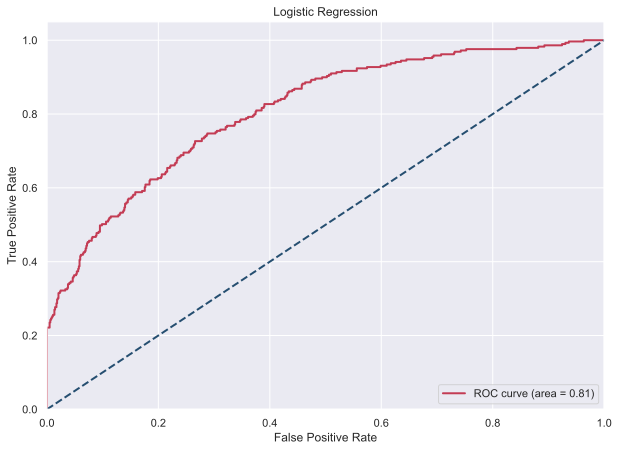

In [17]:
roc_auc_plot(y_test, y_score, 'Logistic Regression')

<div class="alert alert-block alert-info"> 
<b>Comments</b><br>
- Logistic Regression ROC-AUC - 0.809. In general, the model can separate classes.<br>
- Overfitting - 5.1%. Within acceptable limits.<br>
</div>

**SVM. Baseline.**<br>

In [18]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=RAND, probability=True))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_score = pipeline.predict_proba(X_test)

In [19]:
metrics = pd.concat([
    metrics,
    get_metrics.get_metrics_classification(y_test, y_pred, y_score, name='SVM')
])

round(metrics.set_index('model'), 3)

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
Logistic Regression,0.798,0.809,0.741,0.346,0.472,0.432
SVM,0.799,0.766,0.746,0.346,0.473,0.474


In [20]:
check_overfitting(pipeline,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=get_metrics.roc_auc_score)

roc_auc_score train: 0.728
roc_auc_score test: 0.652
delta = 11.6 %


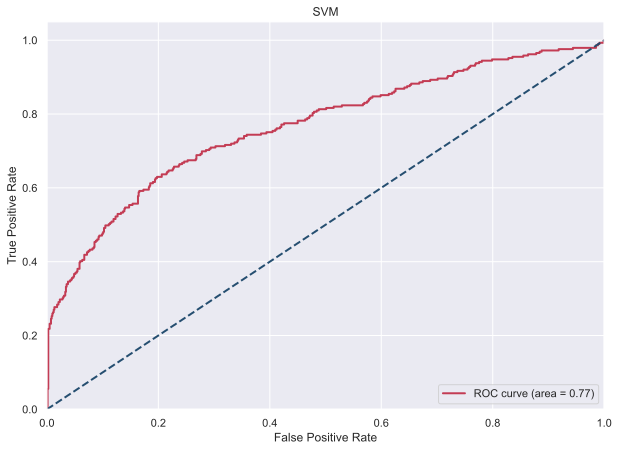

In [21]:
roc_auc_plot(y_test, y_score, 'SVM')

<div class="alert alert-block alert-info"> 
<b>Comments</b><br>
- SVM ROC-AUC - 0.766. In general, the model can separate classes, but worse than Logistic regression.<br>
- Overfitting - 11.16%. Within acceptable limits.<br>
</div>

**Random Forest. Baseline.**<br>

In [22]:
rf_classifier = RandomForestClassifier(random_state=RAND)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
y_score = rf_classifier.predict_proba(X_test)

In [23]:
metrics = pd.concat([
    metrics,
    get_metrics.get_metrics_classification(y_test,
                                           y_pred,
                                           y_score,
                                           name='Random Forest')
])

round(metrics.set_index('model'), 3)

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
Logistic Regression,0.798,0.809,0.741,0.346,0.472,0.432
SVM,0.799,0.766,0.746,0.346,0.473,0.474
Random Forest,0.794,0.776,0.733,0.332,0.457,0.554


In [24]:
check_overfitting(rf_classifier,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=get_metrics.roc_auc_score)

roc_auc_score train: 1.000
roc_auc_score test: 0.645
delta = 55.1 %


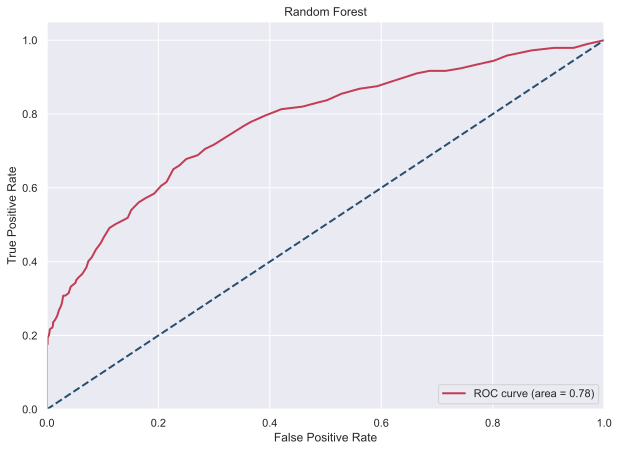

In [25]:
roc_auc_plot(y_test, y_score, 'Random Forest')

<div class="alert alert-block alert-info"> 
<b>Comments</b><br>
- Random Forest ROC-AUC - 0.776. In general, the model can separate classes, bur worse than Logistic Regression.<br>
- Overfitting - 55.1%. We observe strong overfitting.<br>
</div>

**XGBoost. Baseline.**<br>

In [26]:
xgb_classifier = XGBClassifier(scale_pos_weight=ratio, random_state=RAND)
eval_set = [(X_val, y_val)]

xgb_classifier.fit(X_train_,
                   y_train_,
                   eval_metric='auc',
                   eval_set=eval_set,
                   early_stopping_rounds=100,
                   verbose=0)

y_pred = xgb_classifier.predict(X_test)
y_score = xgb_classifier.predict_proba(X_test)

In [27]:
metrics = pd.concat([
    metrics,
    get_metrics.get_metrics_classification(y_test,
                                           y_pred,
                                           y_score,
                                           name='XGBoost')
])

round(metrics.set_index('model'), 3)

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
Logistic Regression,0.798,0.809,0.741,0.346,0.472,0.432
SVM,0.799,0.766,0.746,0.346,0.473,0.474
Random Forest,0.794,0.776,0.733,0.332,0.457,0.554
XGBoost,0.744,0.779,0.508,0.571,0.537,0.501


In [28]:
check_overfitting(xgb_classifier,
                  X_train_,
                  y_train_,
                  X_test,
                  y_test,
                  metric_fun=get_metrics.roc_auc_score)

roc_auc_score train: 0.842
roc_auc_score test: 0.688
delta = 22.4 %


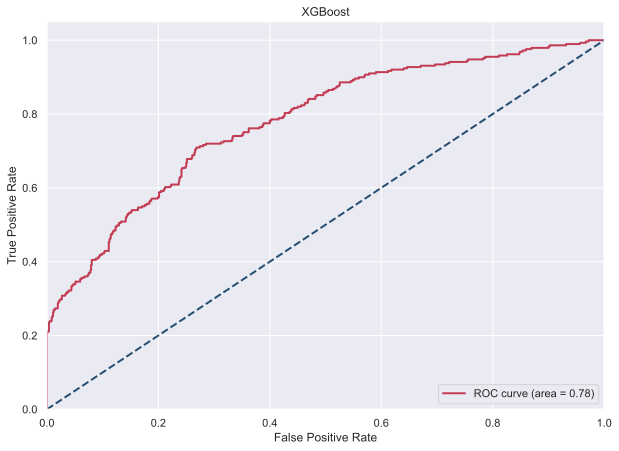

In [29]:
roc_auc_plot(y_test, y_score, 'XGBoost')

<div class="alert alert-block alert-info"> 
<b>Comments</b><br>
- XGBoost ROC-AUC - 0.779. In general, the model can separate classes, but worse than Logistic Regression.<br>
- Overfitting - 22.4%. We observe strong overfitting.<br>
</div>

**LightGBM. Baseline.**<br>

In [30]:
lgbm_classifier = LGBMClassifier(scale_pos_weight=ratio, random_state=RAND)
eval_set = [(X_val, y_val)]

lgbm_classifier.fit(X_train_,
                    y_train_,
                    eval_metric='auc',
                    eval_set=eval_set,
                    early_stopping_rounds=100,
                    verbose=0)

y_pred = lgbm_classifier.predict(X_test)
y_score = lgbm_classifier.predict_proba(X_test)

In [31]:
metrics = pd.concat([
    metrics,
    get_metrics.get_metrics_classification(y_test,
                                           y_pred,
                                           y_score,
                                           name='LightGBM')
])

round(metrics.set_index('model'), 3)

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
Logistic Regression,0.798,0.809,0.741,0.346,0.472,0.432
SVM,0.799,0.766,0.746,0.346,0.473,0.474
Random Forest,0.794,0.776,0.733,0.332,0.457,0.554
XGBoost,0.744,0.779,0.508,0.571,0.537,0.501
LightGBM,0.760,0.780,0.538,0.561,0.549,0.494


In [32]:
check_overfitting(lgbm_classifier,
                  X_train_,
                  y_train_,
                  X_test,
                  y_test,
                  metric_fun=get_metrics.roc_auc_score)

roc_auc_score train: 0.843
roc_auc_score test: 0.696
delta = 21.2 %


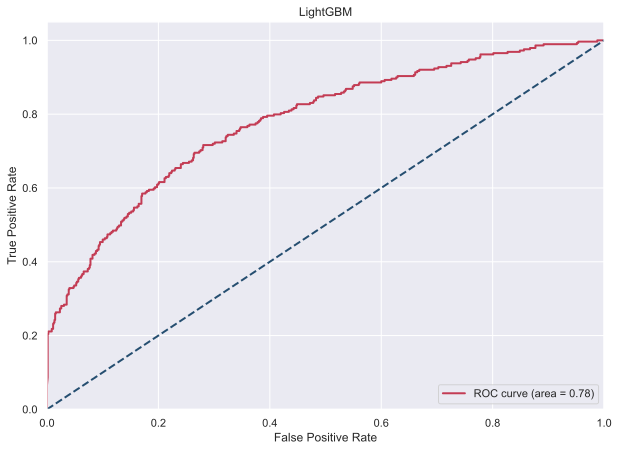

In [33]:
roc_auc_plot(y_test, y_score, 'LightGBM')

<div class="alert alert-block alert-info"> 
<b>Comments</b><br>
- LightGBM ROC-AUC - 0.780. In general, the model can separate classes, but worse than Logistic regression.<br>
- Overfitting - 21.2%. We observe strong overfitting.<br>
</div>

**CatBoost. Baseline.**<br>

In [34]:
cb_classifier = CatBoostClassifier(scale_pos_weight=ratio,
                                   eval_metric='AUC',
                                   allow_writing_files=False,
                                   random_state=RAND)

eval_set = [(X_val, y_val)]

cb_classifier.fit(X_train_,
                  y_train_,
                  eval_set=eval_set,
                  early_stopping_rounds=100,
                  verbose=0)

y_pred = cb_classifier.predict(X_test)
y_score = cb_classifier.predict_proba(X_test)

In [35]:
metrics = pd.concat([
    metrics,
    get_metrics.get_metrics_classification(y_test,
                                           y_pred,
                                           y_score,
                                           name='CatBoost')
])

round(metrics.set_index('model'), 3)

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
Logistic Regression,0.798,0.809,0.741,0.346,0.472,0.432
SVM,0.799,0.766,0.746,0.346,0.473,0.474
Random Forest,0.794,0.776,0.733,0.332,0.457,0.554
XGBoost,0.744,0.779,0.508,0.571,0.537,0.501
LightGBM,0.760,0.780,0.538,0.561,0.549,0.494
CatBoost,0.766,0.802,0.544,0.623,0.581,0.494


In [36]:
check_overfitting(cb_classifier,
                  X_train_,
                  y_train_,
                  X_test,
                  y_test,
                  metric_fun=get_metrics.roc_auc_score)

roc_auc_score train: 0.835
roc_auc_score test: 0.719
delta = 16.1 %


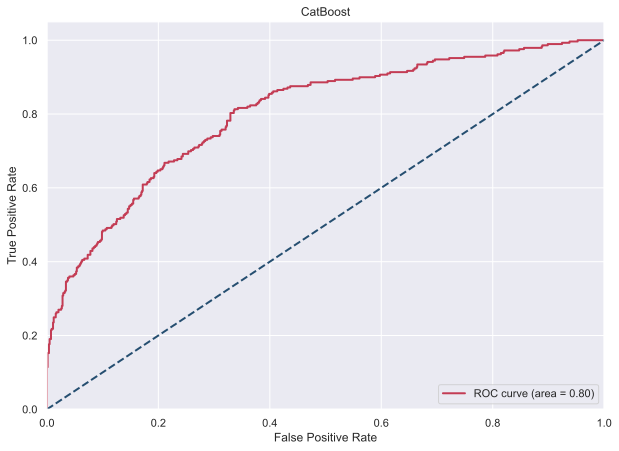

In [37]:
roc_auc_plot(y_test, y_score, 'CatBoost')

<div class="alert alert-block alert-info"> 
<b>Comments</b><br>
- CatBoost ROC-AUC - 0.802. In general, the model can separate classes.<br>
- Overfitting - 16.1%. Overfitting at an acceptable level.<br>
</div>

In [38]:
error_columns = ['Logloss']

evaluate_metrics = metrics.set_index('model').style.highlight_max(
    subset=['Accuracy','ROC_AUC', 'Precision', 'Recall', 'f1'], color='green', axis=0) \
    .highlight_min(subset=error_columns, color='lightgreen', axis=0)

evaluate_metrics

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
Logistic Regression,0.798016,0.808925,0.740741,0.346021,0.471698,0.432350
SVM,0.798918,0.765558,0.746269,0.346021,0.472813,0.473947
Random Forest,0.794409,0.776270,0.732824,0.332180,0.457143,0.553602
XGBoost,0.743913,0.779431,0.507692,0.570934,0.537459,0.501440
LightGBM,0.760144,0.780327,0.538206,0.560554,0.549153,0.493640
CatBoost,0.765555,0.801983,0.543807,0.622837,0.580645,0.493977


**Final conclusions.**<br>
In the next stage (Model tuning) we will use 2 models:<br>
1. Logistic Regression.<br>
2. CatBoost.<br>